In [1]:
#run this to install the package
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

## **From Sheet to DataFrame to Regression Object**

In [4]:
US_Data = "1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU"

## **USA Data Cleaning**

In [5]:
x = read_sheets(US_Data,sheet='Food Expenditures 2021')
x["j"] = x["food_name"]
x = x.set_index(['i','t','m','j'])["grams"].squeeze()

# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2021")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)

### Filter Data Down

In [6]:
food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(350).index
x_filtered = x[x.index.get_level_values('j').isin(top_foods)]
y_filtered = y[y.index.get_level_values('j').isin(top_foods)]

# Step 3.2: Random sample of 500 households
sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)

# Filter y and d to match
y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_sample:", y_sample.shape)
print("Shape of d_sample:", d_sample.shape)

Shape of y_sample: (22436,)
Shape of d_sample: (1750, 3)


## **Build Price Data**

In [9]:
#Add price data
p = pd.read_csv("proj3_min_cost_data - prices.csv")

# Change column names to actual unit values
p["u"] = "Kg"

p["m"] = "USA"

# Adjust price to per Kg from per g
p["price"] = p["price"] * 10

# Filter for only 2017/2018 prices
p = p[p["t"] == "2017/2018"]

# Change price data from 2017/2018 to 2021 using avg US CPIs in 2017/2018 and 2021
cpi_2021 = 271.0
cpi_2018 = 250.0
p["price"] = p["price"] * (cpi_2021/cpi_2018)

p["t"] = "2021"


codes = pd.read_csv("proj3_min_cost_data - recipes.csv")

codes = codes[["parent_foodcode", "parent_desc"]]
c = codes.groupby("parent_foodcode").first()
c.rename(columns = {"parent_foodcode": "j"})
p = p.join(c, on="j")
p_with_j = p # use later on for nutrition data
p = p.drop("j", axis=1)
p = p.rename(columns = {"parent_desc":"j"})

# Now prices
p = p.set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')
# Identify the common keys between x_filtered.index.levels[-1] and p.columns
common_keys = p.columns.intersection(x_filtered.index.levels[-1])

# Now subset p with these keys and transpose the result.
p = p[common_keys].T

## **Run Regression**

In [10]:
from cfe import Regression

# Run the regression
result = Regression(y=y_filtered, d=d_sample, compute_se=False, rectify=False, min_obs=10, min_prop_items=0.002)

In [11]:
predicted = result.predicted_expenditures()
predicted.head()

i       t     m    j                               
130390  2021  USA  Apple, raw                          153.664292
                   Banana, raw                         108.128735
                   Butter, stick                         8.217772
                   Cheese, nfs                          19.828239
                   Coffee creamer, liquid, flavored     31.340555
dtype: float64

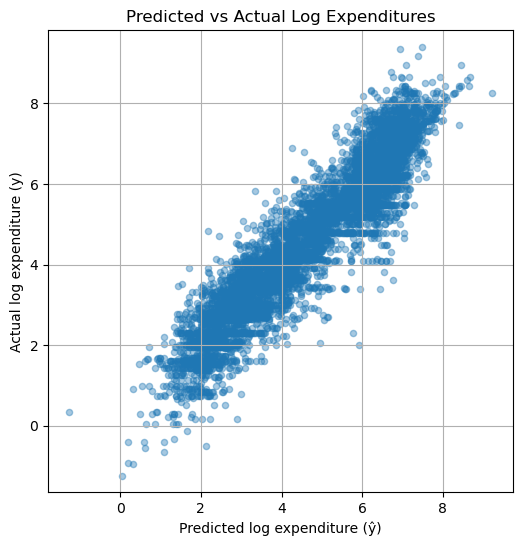

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create DataFrame of actual vs predicted log expenditures
df = pd.DataFrame({
    'y': y_sample,
    'yhat': result.get_predicted_log_expenditures()
})

# Drop missing values (some may not match if data was trimmed)
df = df.dropna()

# Plot
df.plot.scatter(x='yhat', y='y', alpha=0.4, figsize=(6, 6))
plt.title("Predicted vs Actual Log Expenditures")
plt.xlabel("Predicted log expenditure (ŷ)")
plt.ylabel("Actual log expenditure (y)")
plt.grid(True)
plt.axis("equal")  # force square axes
plt.show()

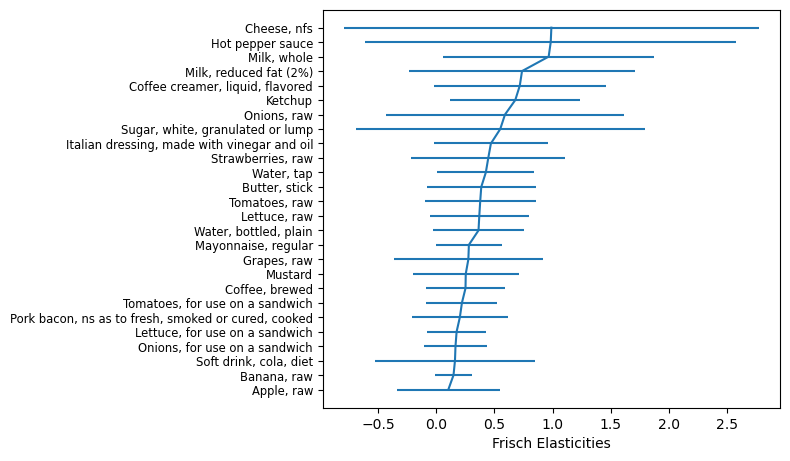

In [13]:
ax = result.graph_beta()

In [14]:
foods_in_regression = result.beta.index.get_level_values('j').unique()

In [15]:
result.get_gamma().head()

k,age,sex,log_household,Constant
j,,,,
"Apple, raw",0.002788,-0.042821,-0.030882,5.036137
"Banana, raw",0.000453,-0.119854,-0.016291,4.714381
"Butter, stick",0.002774,-0.121417,-0.274499,2.097622
"Cheese, nfs",-0.003574,-0.095129,-0.015629,2.946690
"Coffee creamer, liquid, flavored",-0.009049,-0.133970,-0.215899,3.424015


<Axes: ylabel='Density'>

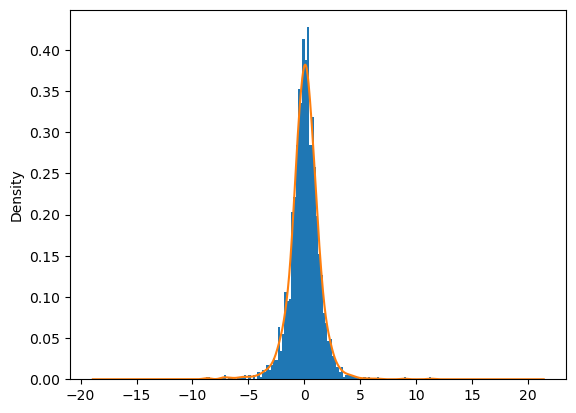

In [16]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

## Saving Regression

In [17]:
result.to_pickle('us_estimates_2021.rgsn')

In [18]:
import cfe

# Load the result back into memory
result = cfe.regression.read_pickle('us_estimates_2021.rgsn')

## Demand and Utility

Having estimated the demand system, we can examine the implied demand curves.

## Budgets
Get food budget for all households, then find median budget:

In [19]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

**Reference Prices**
  
Choose reference prices. Here we’ll choose a particular year, and average prices across markets. If you wanted to focus on particular market you’d do this differently.

In [20]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)

# Instead of directly indexing with result.beta.index (which fails for missing keys),
# reindex pbar to have the same index as result.beta and fill missing prices with 1.
pbar = pbar.reindex(result.beta.index, fill_value=1)

# (Optional) Get the common keys, which should be all keys in result.beta.index:
common_keys = pbar.index.intersection(result.beta.index)
pbar = pbar.loc[common_keys]

# Replace any remaining missing values with 1.
pbar = pbar.replace(np.nan, 1)

# Finally, define a function to change the price of a single good in the price vector.
def my_prices(p0, j, p=pbar):
    """
    Change price of the jth good to p0, holding all other prices fixed.
    
    Parameters:
      p0 : float
          New price for the jth good.
      j : label
          Identifier for the good (must be present in p).
      p : pd.Series
          Price vector (default is pbar).
    
    Returns:
      pd.Series : A new price vector with the updated value.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

common_keys

Index(['Apple, raw', 'Banana, raw', 'Butter, stick', 'Cheese, nfs',
       'Coffee creamer, liquid, flavored', 'Coffee, brewed', 'Grapes, raw',
       'Hot pepper sauce', 'Italian dressing, made with vinegar and oil',
       'Ketchup', 'Lettuce, for use on a sandwich', 'Lettuce, raw',
       'Mayonnaise, regular', 'Milk, reduced fat (2%)', 'Milk, whole',
       'Mustard', 'Onions, for use on a sandwich', 'Onions, raw',
       'Pork bacon, ns as to fresh, smoked or cured, cooked',
       'Soft drink, cola, diet', 'Strawberries, raw',
       'Sugar, white, granulated or lump', 'Tomatoes, for use on a sandwich',
       'Tomatoes, raw', 'Water, bottled, plain', 'Water, tap'],
      dtype='object', name='j')

## **Demand Curve for One Food**

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline

def plot_demand_curve(good):
    """
    Plot the demand curve for a given good over a range of price scales.
    
    Parameters
    ----------
    good : str
        The common key (food identifier) for which you want the demand curve,
        e.g. "Banana, raw".
        
    Global Variables (should be defined before calling this function):
      pbar         : pd.Series of reference prices (indexed by food identifier)
      result       : an object with a demands() method and attribute beta.index.
      xref         : reference expenditure vector (e.g., median household expenditures)
      xbar         : household total expenditures used to compute quantiles.
      my_prices()  : function that returns a modified price vector.
    """
    # Suppress warnings about negative beta values
    warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
    
    # Reindex pbar so that it has the same index as result.beta.index, filling missing keys with 1.
    pbar_local = pbar.reindex(result.beta.index, fill_value=1)
    
    # Define a range of scale factors: vary prices from 50% to 200% of the reference price.
    scale = np.linspace(0.5, 2, 20)
    
    # Compute demand for the given good at different price levels.
    # Wrap the list comprehensions in a warnings.catch_warnings block to suppress any warnings during computation.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
        median_demand = [result.demands(xref, my_prices(pbar_local[good] * s, good, pbar_local))[good]
                         for s in scale]
        demand_q25 = [result.demands(xbar.quantile(0.25), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                      for s in scale]
        demand_q75 = [result.demands(xbar.quantile(0.75), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                      for s in scale]
    
    # Create the plot.
    plt.figure(figsize=(8, 6))
    plt.plot(median_demand, scale, marker="o", label="Median Budget")
    plt.plot(demand_q25, scale, marker="s", label="25th Percentile Budget")
    plt.plot(demand_q75, scale, marker="^", label="75th Percentile Budget")
    
    # Add axis labels, title, legend, and grid.
    plt.xlabel(f"Quantities of {good} Demanded")
    plt.ylabel(f"Price (relative to base of {pbar_local[good]:.2f})")
    plt.title(f"Demand Curve for {good}")
    plt.legend()
    plt.grid(True)
    plt.show()

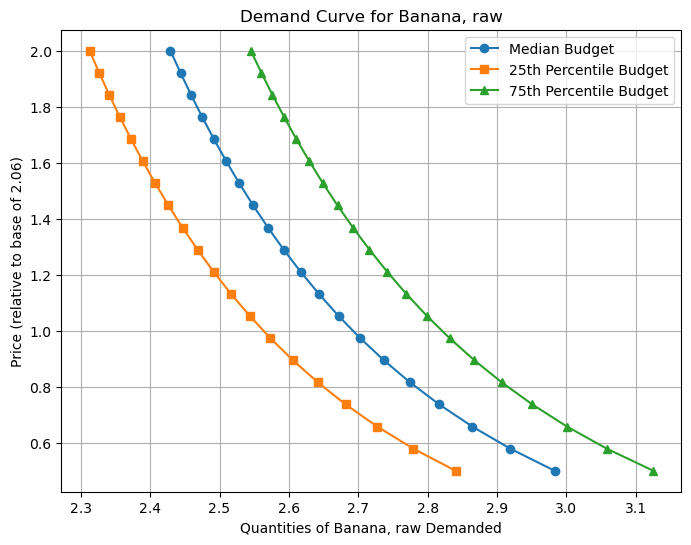

In [22]:
plot_demand_curve('Banana, raw')

## **Demand Curve for More than One good**

In [23]:
def plot_demand_curves(goods):
    """
    Plot demand curves for multiple goods over a range of price scales.
    
    Parameters
    ----------
    goods : tuple or list of str
        The food identifiers (common keys) for which you want to plot demand curves.
        For example: ('Banana, raw', 'Apple, raw', 'Milk, whole')
    
    Global variables required:
      - pbar: pd.Series with reference prices (indexed by food identifiers)
      - result: an object with methods demands() and attribute beta.index
      - xref: reference expenditure vector (e.g., median expenditures)
      - xbar: household total expenditures (used for quantile calculations)
      - my_prices(): function to adjust the price vector
    """
    # Suppress specific warnings (from consumerdemands._utils)
    warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
    
    # Ensure pbar covers all keys in result.beta.index; fill missing values with 1.
    pbar_local = pbar.reindex(result.beta.index, fill_value=1)
    
    # Define a range of scale factors to vary the price from 50% to 200% of reference.
    scale = np.linspace(0.5, 2, 20)
    
    # Create a new figure for the plot.
    plt.figure(figsize=(10, 8))
    
    # Loop over each good in the input tuple/list.
    for good in goods:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Setting negative values of beta to zero")
            # Compute the demand for the given good at various price levels.
            median_demand = [result.demands(xref, my_prices(pbar_local[good] * s, good, pbar_local))[good]
                             for s in scale]
            demand_q25 = [result.demands(xbar.quantile(0.25), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                          for s in scale]
            demand_q75 = [result.demands(xbar.quantile(0.75), my_prices(pbar_local[good] * s, good, pbar_local))[good]
                          for s in scale]
        
        # Plot each demand curve with distinct line styles and markers.
        plt.plot(median_demand, scale,
                 label=f"{good} (Median Budget)")
        plt.plot(demand_q25, scale,
                 label=f"{good} (25th Percentile Budget)")
        plt.plot(demand_q75, scale,
                 label=f"{good} (75th Percentile Budget)")
    
    # Add labels, title, legend, and grid.
    plt.xlabel("Quantity Demanded")
    # This label uses the base reference price of the first good in the list for display.
    plt.ylabel(f"Price (relative to base of {pbar_local[goods[0]]:.2f})")
    plt.title("Demand Curves for Selected Goods")
    plt.legend()
    plt.grid(True)
    plt.show()

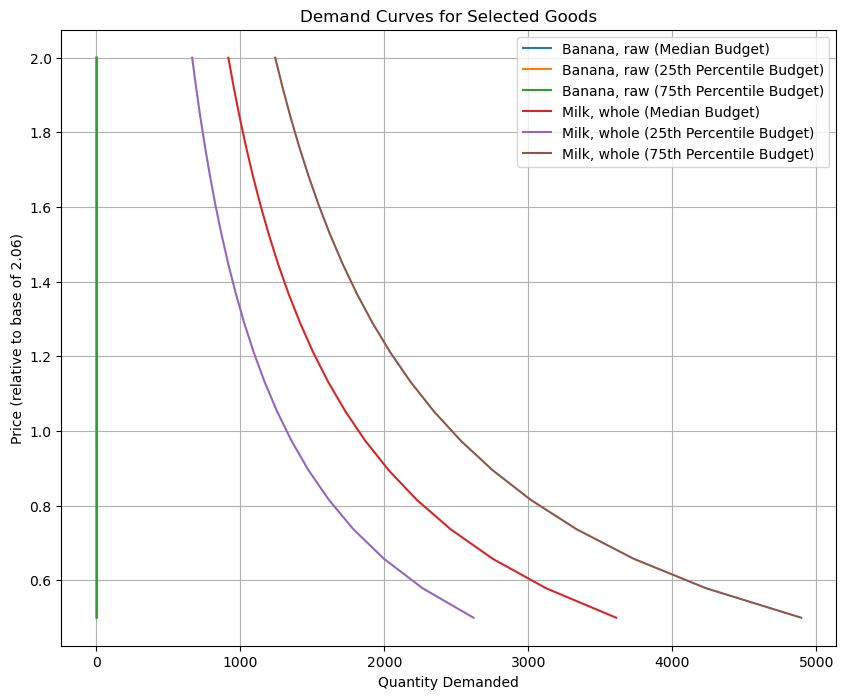

In [24]:
# Example usage:
plot_demand_curves(('Banana, raw', 'Milk, whole'))

## **Engle Curves**

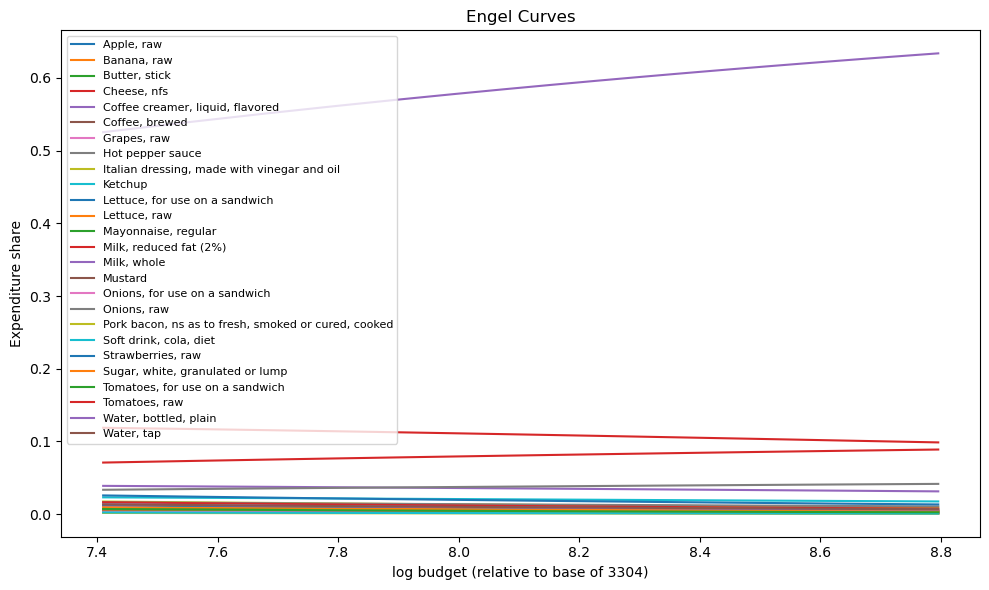

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create a range of budgets by scaling the base budget xref.
scale = np.linspace(0.5, 2, 20)

# Loop over each good in pbar.
for good in pbar.index:
    shares = []
    for s in scale:
        budget = s * xref  # Adjust budget by the scale factor.
        # Compute expenditures for all goods at this budget.
        exp_series = result.expenditures(budget, pbar)
        # Compute the expenditure share for the current good.
        share = exp_series[good] / budget
        shares.append(share)
    # Plot the Engel curve for the current good,
    # using the log-budget (log(scale * xref)) on the x-axis.
    ax.plot(np.log(scale * xref), shares, label=good)

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves')

# Add a legend to label each curve with the good’s name.
ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()